# The slow(est) way to generate an ROC curve

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyrsm as rsm
import seaborn as sns
from sklearn.metrics import auc, roc_curve

In [2]:
# load data
bbb = pd.read_parquet("data/bbb.parquet")

In [3]:
# review the data
rsm.md("data/bbb_description.md")

# BookBinders Book Club

Information on purchasing history and demographics for 50,000 of the BookBinders Book Club's customers'. Variables included in the dataset are described below

## Variables

* acctnum: Customer account number
* gender: Customer gender identity (M = male, F = female, O = Other or unknown)
* state: State where customer lives (2-character abbreviation)
* zip: ZIP code (5-digit)
* zip3: First 3 digits of ZIP code
* first: Number of months since first purchase
* last: Number of months since most recent purchase
* book: Total dollars spent on books
* nonbook: Total dollars spent on non-book products
* total: Total dollars spent
* purch: Total number of books purchased
* child: Total number of children's books purchased
* youth: Total number of youth books purchased
* cook: Total number of cook books purchased 
* do_it: Total number of do-it-yourself books purchased 
* reference: Total number of reference books purchased 
* art: Total number of art books purchased 
* geog: Total number of geography books purchased 
* buyer: Did the customer buy The Art History of Florence?  (yes, no)
* training: Dummy variable that splits the dataset into a training (1) and validation (0) dataset


In [4]:
rsm.__version__

'0.9.26'

In [5]:
evar = [
    "gender",
    "last",
    "total",
    "child",
    "youth",
    "cook",
    "do_it",
    "reference",
    "art",
    "geog",
]

In [6]:
lr = rsm.model.logistic({"bbb": bbb}, rvar="buyer", lev="yes", evar=evar)
lr.summary()

Logistic regression (GLM)
Data                 : bbb
Response variable    : buyer
Level                : yes
Explanatory variables: gender, last, total, child, youth, cook, do_it, reference, art, geog
Null hyp.: There is no effect of x on buyer
Alt. hyp.: There is an effect of x on buyer

              OR     OR%  coefficient  std.error  z.value p.value     
Intercept  0.093  -90.7%        -2.37      0.050  -47.518  < .001  ***
gender[M]  2.165  116.5%         0.77      0.037   21.065  < .001  ***
gender[O]  1.118   11.8%         0.11      0.074    1.507   0.132     
last       0.910   -9.0%        -0.09      0.003  -33.916  < .001  ***
total      1.001    0.1%         0.00      0.000    5.626  < .001  ***
child      0.830  -17.0%        -0.19      0.017  -10.759  < .001  ***
youth      0.893  -10.7%        -0.11      0.026   -4.332  < .001  ***
cook       0.763  -23.7%        -0.27      0.017  -15.778  < .001  ***
do_it      0.583  -41.7%        -0.54      0.027  -19.992  < .001  ***


In [7]:
bbb["pred_logit"] = lr.predict(bbb)["prediction"]

Function to calculate the TPR and TNR at different trade-off values (and break-even values)

In [8]:
def slow_roc(outcome, pred, cost, margin):
    tbl = pd.DataFrame(
        {
            "cost": cost,
            "margin": margin,
            "BE": cost / margin,
            "TP": np.nan,
            "FP": np.nan,
            "TN": np.nan,
            "FN": np.nan,
            "TNR": np.nan,
            "TPR": np.nan,
        }
    )
    for i in range(len(cost)):
        breakeven = tbl.loc[i, "BE"]
        TP = np.where((pred > breakeven) & outcome, 1, 0).sum()
        FP = np.where((pred > breakeven) & (outcome == False), 1, 0).sum()
        TN = np.where((pred <= breakeven) & (outcome == False), 1, 0).sum()
        FN = np.where((pred <= breakeven) & outcome, 1, 0).sum()
        TPR = TP / (TP + FN)
        TNR = TN / (TN + FP)
        tbl.iloc[i, 3:9] = [TP, FP, TN, FN, TNR, TPR]

    return tbl

Creating the data for the ROC curve

In [9]:
outcome = bbb["buyer"] == "yes"
pred = bbb["pred_logit"]
cost = np.arange(0.0, 6.0, 0.05)
roc_data = slow_roc(outcome, pred, cost=cost, margin=6)

Plotting the ROC curve. The axes are TPR and TNR

* TPR is the true positive rate: TP / (TP + FN)

The TPR measures the proportion of actual positive outcomes that are correctly predicted by the model

* TNR is the true negative rate: TN / (TN + FP)

The TNR measures the proportion of actual negative outcomes that are correctly predicted by the model


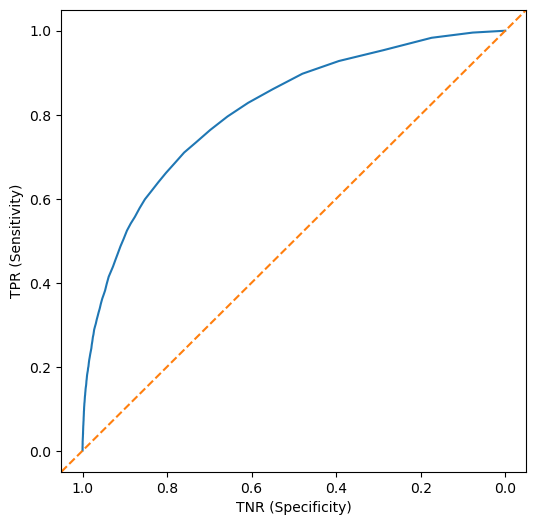

In [10]:
#plt.cla()
fig = plt.figure(figsize=(6, 6))  # Set the figure size to be square
fig = sns.lineplot(x="TNR", y="TPR", data=roc_data)
fig.set(ylabel="TPR (Sensitivity)", xlabel="TNR (Specificity)")
plt.gca().invert_xaxis()
fig = fig.plot([0, 1], [0, 1], transform=fig.transAxes, linestyle="--")

Calculating the TPR and TNR for the break-even point in the BBB case

In [11]:
bbb_to = slow_roc(outcome, pred, cost=np.array([0.5]), margin=6)

In [12]:
bbb_to["TNR"][0]

0.731144729319671

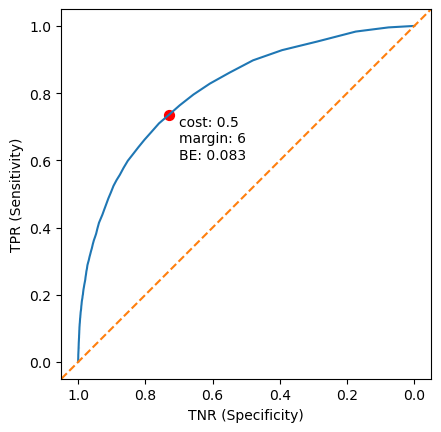

In [13]:
plt.cla()
fig = sns.lineplot(x="TNR", y="TPR", data=roc_data)
fig.set(ylabel="TPR (Sensitivity)", xlabel="TNR (Specificity)")
plt.gca().invert_xaxis()
plt.gca().set_aspect("equal", adjustable="box")
fig.plot([0, 1], [0, 1], transform=fig.transAxes, linestyle="--")
plt.scatter(bbb_to["TNR"], bbb_to["TPR"], s=50, color="red")
plt.annotate("cost: 0.5\nmargin: 6\nBE: 0.083", (bbb_to["TNR"][0] - 0.03, bbb_to["TPR"][0] - 0.13))
plt.show()

In [14]:
bbb_to = slow_roc(outcome, pred, cost=np.array([6]), margin=6)

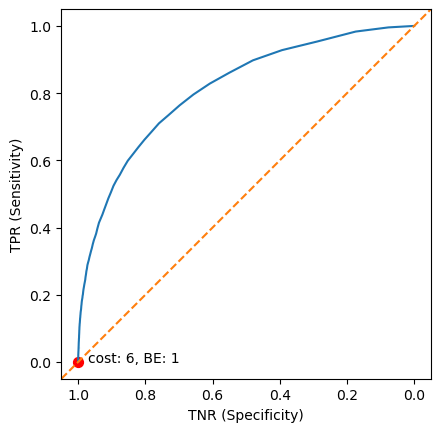

In [15]:
plt.cla()
fig = sns.lineplot(x="TNR", y="TPR", data=roc_data)
fig.set(ylabel="TPR (Sensitivity)", xlabel="TNR (Specificity)")
plt.gca().invert_xaxis()
plt.gca().set_aspect("equal", adjustable="box")
fig.plot([0, 1], [0, 1], transform=fig.transAxes, linestyle="--")
plt.scatter(bbb_to["TNR"], bbb_to["TPR"], s=50, color="red")
plt.annotate("cost: 6, BE: 1", (bbb_to["TNR"][0] - 0.03, bbb_to["TPR"][0]))
plt.show()

In [16]:
bbb_to = slow_roc(outcome, pred, cost=np.array([0]), margin=6)

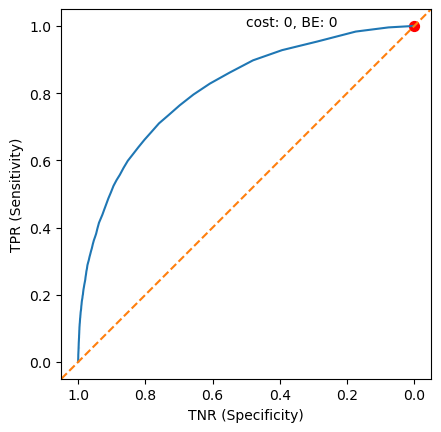

In [17]:
plt.cla()
fig = sns.lineplot(x="TNR", y="TPR", data=roc_data)
fig.set(ylabel="TPR (Sensitivity)", xlabel="TNR (Specificity)")
plt.gca().invert_xaxis()
plt.gca().set_aspect("equal", adjustable="box")
fig.plot([0, 1], [0, 1], transform=fig.transAxes, linestyle="--")
plt.scatter(bbb_to["TNR"], bbb_to["TPR"], s=50, color="red")
plt.annotate("cost: 0, BE: 0", (bbb_to["TNR"][0] + 0.5, bbb_to["TPR"][0]))
plt.show()

Confirm plot with roc_curve from sklearn

In [18]:
bbb["buyer_yes"] = rsm.ifelse(bbb.buyer == "yes", 1, 0)
fpr, tpr, thresholds = roc_curve(bbb.buyer_yes, bbb.pred_logit)
py_roc = pd.DataFrame({"FPR": fpr, "TPR": tpr})
py_roc

,FPR,TPR
0,0.000000,0.000000
1,0.000000,0.000221
2,0.000000,0.002654
3,0.000022,0.002654
4,0.000022,0.007519
...,...,...
11364,0.990391,1.000000
11365,0.990435,1.000000
11366,0.991051,1.000000
11367,0.991095,1.000000


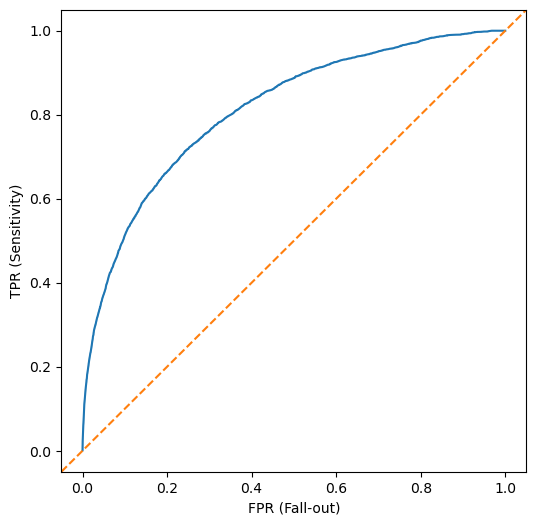

In [19]:
# slow!
# plt.cla≥()
fig = plt.figure(figsize=(6, 6))  # Set the figure size to be square
fig = sns.lineplot(x="FPR", y="TPR", data=py_roc)
fig.set(ylabel="TPR (Sensitivity)", xlabel="FPR (Fall-out)")
fig = fig.plot([0, 1], [0, 1], transform=fig.transAxes, linestyle="--")
# plt.show()

### Probabilistic interpretation of AUC

See https://www.alexejgossmann.com/auc/ for a very nice dicsussion

In [20]:
# Adapted from Alexej's code
s = 0
did_buy = np.where(outcome)[0]
did_not_buy = np.where(outcome == False)[0]
for i in did_buy:
    s = s + np.where(pred[i] > pred[did_not_buy], 1, 0).sum()
    s = s + np.where(pred[i] == pred[did_not_buy], 1, 0).sum() / 2

s / ((outcome == True).sum() * (outcome == False).sum())

0.8117872663773604

Lets compare that result to what we would get with a formal calculation:

In [21]:
auc(fpr, tpr)

0.8117872663773604

Lets try a sampling approach

In [22]:
pred_did_buy = pred[did_buy]
pred_did_not_buy = pred[did_not_buy]
nr = 2000
(np.random.choice(pred_did_buy, nr) > np.random.choice(pred_did_not_buy, nr)).mean()

0.801

Lets do repeated simulation as that should get us closer to the true value

In [23]:
rep = 100
s = np.array([np.nan] * rep)
for i in range(0, rep):
    s[i] = (
        np.random.choice(pred_did_buy, nr) > np.random.choice(pred_did_not_buy, nr)
    ).mean()

s.mean()

0.8119650000000002

To calculate many measure of model performance in one step, use the `evalbin` function from the `pyrsm` packages

In [24]:
rsm.evalbin(bbb, "buyer", "yes", "pred_logit", cost=0.5, margin=6)

,Type,predictor,TP,FP,TN,FN,total,TPR,TNR,precision,Fscore,accuracy,kappa,profit,index,ROME,contact,AUC
0,All,pred_logit,3322,12227,33251,1200,50000,0.735,0.731,0.214,0.331,0.731,0.222,12157.5,1.0,1.564,0.311,0.812


In the development version of `pyrsm` there is a convenience function to calculate auc (version 0.4.7).  

In [25]:
rsm.auc(bbb.buyer_yes, bbb.pred_logit).round(10)

0.8117872664

In [26]:
fpr, tpr, thresholds = roc_curve(bbb.buyer_yes, bbb.pred_logit)
auc(fpr, tpr).round(10)

0.8117872664

Code from slides used in class ...

In [27]:
auc_100 = pd.read_csv("data/auc-100.csv")
auc_100


,buyer,probability
0,yes,0.45
1,yes,0.62
2,yes,0.22
3,yes,0.86
4,yes,0.67
5,yes,0.43
6,no,0.05
7,no,0.01
8,no,0.02
9,no,0.04


In [28]:
pred_did_buy = auc_100.loc[auc_100["buyer"] == "yes", "probability"]
pred_did_not_buy = auc_100.loc[auc_100["buyer"] == "no", "probability"]
np.mean(
    np.random.choice(pred_did_buy, size=1000)
    > np.random.choice(pred_did_not_buy, size=1000)
)


1.0

In [29]:
rsm.auc(auc_100.buyer, auc_100.probability, "yes")


1.0

In [30]:
auc_50 = pd.read_csv("data/auc-50.csv")
auc_50


,buyer,probability
0,yes,0.45
1,yes,0.03
2,yes,0.22
3,yes,0.04
4,yes,0.67
5,yes,0.05
6,no,0.05
7,no,0.62
8,no,0.02
9,no,0.86


In [31]:
pred_did_buy = auc_50.loc[auc_50["buyer"] == "yes", "probability"]
pred_did_not_buy = auc_50.loc[auc_50["buyer"] == "no", "probability"]
np.mean(
    np.random.choice(pred_did_buy, size=1000)
    > np.random.choice(pred_did_not_buy, size=1000)
)


0.46

In [32]:
rsm.auc(auc_50.buyer, auc_50.probability, "yes")


0.5

In [33]:
auc_0 = pd.read_csv("data/auc-0.csv")
auc_0


,buyer,probability
0,yes,0.05
1,yes,0.01
2,yes,0.02
3,yes,0.04
4,yes,0.03
5,yes,0.05
6,no,0.45
7,no,0.62
8,no,0.22
9,no,0.86


In [34]:
pred_did_buy = auc_0.loc[auc_0["buyer"] == "yes", "probability"]
pred_did_not_buy = auc_0.loc[auc_0["buyer"] == "no", "probability"]
np.mean(
    np.random.choice(pred_did_buy, size=1000)
    > np.random.choice(pred_did_not_buy, size=1000)
)


0.0

In [35]:
rsm.auc(auc_0.buyer, auc_0.probability, "yes")

1.0